In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

In [2]:
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

from scipy import stats

np.random.seed(42)

In [3]:
data = np.concatenate((stats.norm.rvs(0, 1, size=200), 
                       stats.norm.rvs(10, 1,size=200), 
                       stats.norm.rvs(12, 1, size=200)))

np.random.shuffle(data)

if data.ndim == 1: N = len(data)
else: N, shape = data.shape

max_tables = 5

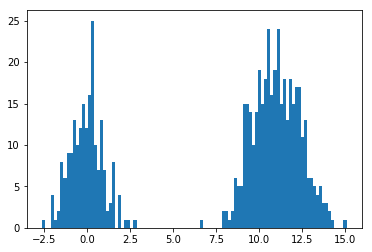

In [4]:
_ = plt.hist(data, bins=100)
plt.show()

In [5]:
def chinese_restaurant_process(N, alpha, max_tables=5):
    if N < 1:
        return None
    
    table_assignments = T.zeros(N, dtype=int)
    next_table = 0
    
    for c in range(N):
        if T.gt((1. * alpha / (alpha + c)), np.random.random()):
            T.set_subtensor(table_assignments[c], next_table)
            next_table += 1
        else:
            p = [(table_assignments[:c] == i).sum().eval() / float(c) 
                  for i in range(next_table)]
            T.set_subtensor(table_assignments[c], np.random.choice(range(next_table), p=p))
        
    return T.extra_ops.to_one_hot(table_assignments, max_tables)

In [6]:
with pm.Model() as model:
    alpha = pm.TruncatedNormal('alpha', mu=1., sd=5., lower=0.)
    pi = pm.Deterministic('pi', chinese_restaurant_process(N, alpha, max_tables))
    
    tau = pm.Gamma('tau', 1., 1., shape=max_tables)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=max_tables)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=max_tables)
    
    pm.NormalMixture('X', pi, mu, tau=lambda_ * tau,
                     observed=data)

In [7]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

alpha_lowerbound__ -1.9823720942266763
tau_log__ -5.0
lambda_interval__ -6.931471805599453
mu -2.303965836337976
X -61899.70946374438


In [8]:
with model:
    trace = pm.sample(1000, nuts_kwargs=dict(target_accept=.9))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, tau, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:09<00:00, 23.57draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


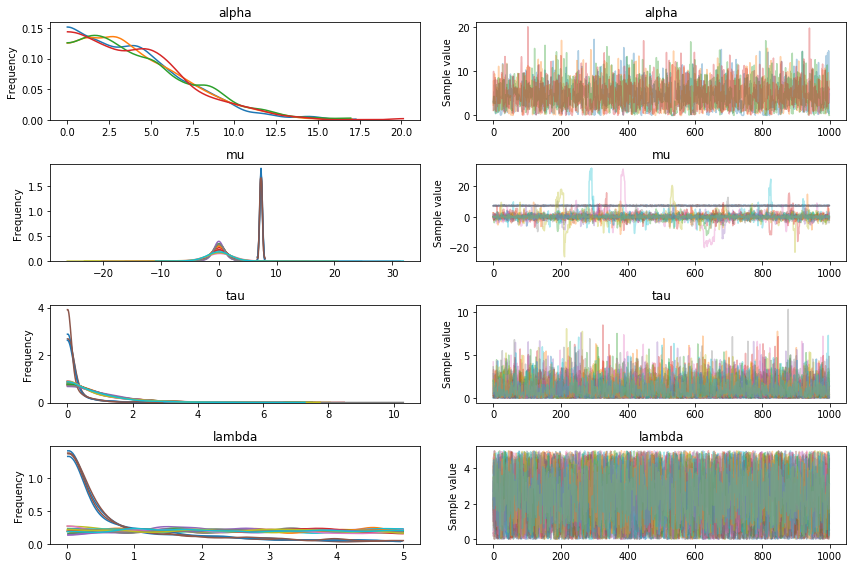

In [13]:
_ = pm.traceplot(trace, varnames=['alpha', 'mu', 'tau', 'lambda'])

In [10]:
post_pdf_contribs = stats.norm.pdf(np.atleast_3d(np.linspace(-3, 15, 600)),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['pi'] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

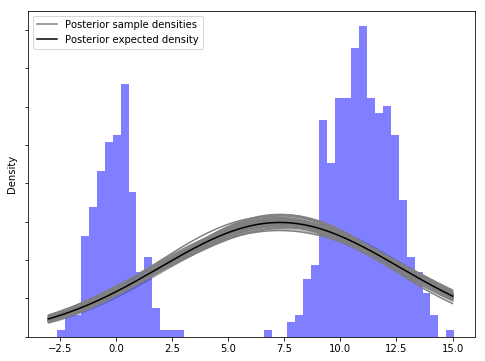

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 50
ax.hist(data, bins=n_bins, normed=True,
        color='blue', lw=0, alpha=0.5)

ax.fill_between(np.linspace(-3, 15, 600), post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45)
ax.plot(np.linspace(-3, 15, 600), post_pdfs[0],
        c='gray', label='Posterior sample densities')
ax.plot(np.linspace(-3, 15, 600), post_pdfs[::100].T, c='gray')
ax.plot(np.linspace(-3, 15, 600), post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density')

ax.set_yticklabels([])
ax.set_ylabel('Density')
ax.legend(loc=2)
plt.show()

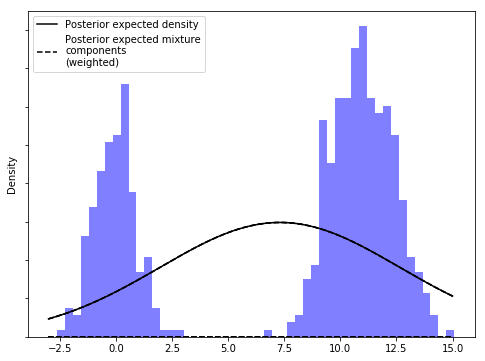

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 50
ax.hist(data, bins=n_bins, normed=True,
        color='blue', lw=0, alpha=0.5)

ax.plot(np.linspace(-3, 15, 600), post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density')
ax.plot(np.linspace(-3, 15, 600), (trace['pi'] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)')
ax.plot(np.linspace(-3, 15, 600), (trace['pi'] * post_pdf_contribs).mean(axis=0),
        '--', c='k');

ax.set_yticklabels([])
ax.set_ylabel('Density')
ax.legend(loc=2)

plt.show()